# Intro

 - The data consists of soccer game results and statistics from the English Premier League from the 2018-2019 season
 - 20 teams participated, and played a combined total of 380 games
 - The games were held from August 10, 2018 to December 20, 2020.


In [131]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(forcats))
suppressPackageStartupMessages(install.packages("DescTools"))
suppressPackageStartupMessages(install.packages("corrplot"))
suppressPackageStartupMessages(library(corrplot))


soccer <- read_csv('data/soccer18-19.csv.gz', show_col_types = T)

Installing DescTools [0.99.45] ...
	OK [linked cache]
Installing corrplot [0.92] ...
	OK [linked cache]


Rows: 380 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Div, Date, HomeTeam, AwayTeam, FTR, HTR, Referee
dbl (16): FTHG, FTAG, HTHG, HTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Executive Summary
 - We first transformed the dataset so we can perform analyses and comparisons by team
 - Next, we compared how each team performed in terms of:
 	1. Total Wins, Losses, and Draws
    2. Fouls, Yellow Cards, and Red Cards
    3. Total Number of Goals Scored
    4. Accuracy and Success in Scoring Goals
 - Lastly, we tried to find good predictors for team winnings.
 - Findings:
 	1. Manchester City and Arsenal are consistently some of the best performers in terms of number of wins, number of goals scored, and accuracy. Between the two, Manchester City incurs fewer fouls, and gets fewer cards in total. 
    	- These may be indicators that these two teams would be good bets in future seasons. 
    2. Half-time results is a good predictor of full time results ($\lambda = 0.3448$). 
     	- Therefore, coaches may be feel reassured in putting newer players in the second half, if the team had already won the first half. 
    3. Total number of red cards are good predictors for total number of wins per team ($\rho = -0.42$). 
     	- One may want to avoid betting for teams that frequently get red cards. 
    4. However, we didn't have sufficient evidence to conclude taht total number of yellow cards and fouls are good predictors for total number of wins per team. 

# Clean and Explore
 - The data is arranged as one row per game. 
 - Since most of our analyses will focus on performance by team, we'll use `pivot_longer` to transform the dataset so one row corresponds to one team per game. 

In [114]:
head(soccer)
soccer_cols <- c("div", "date", "home_team", "away_team","home_ftg", "away_ftg", "ftr", "home_htg", "away_htg", "htr", "referee", 					"home_shots", "away_shots", "home_st", "away_st", "home_foul", "away_foul", "home_corners", "away_corners", 
                	"home_yellow", "away_yellow", "home_red", "away_red")
colnames(soccer) <- soccer_cols
soccer <- soccer %>% mutate(id = 1:nrow(soccer), date = as.Date(date,format='%d/%m/%y'))

soccer_home <- soccer %>% select(!starts_with("away")) %>% 
	rename_all(~stringr::str_replace_all(.,"home_","")) %>% 
	mutate(position = "home")
soccer_away <- soccer %>% select(!starts_with("home")) %>% 
	rename_all(~stringr::str_replace_all(.,"away_","")) %>% 
	mutate(position = "home")
soccer_long <- rbind(soccer_home, soccer_away) %>% 
	mutate(result = case_when((ftr == "H" & position == "home") | (ftr == "A" & position == "away") ~ "win",
                             	ftr == "D" ~ "draw",
                             	TRUE ~ "loss"))

Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,⋯,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E0,10/8/18,Man United,Leicester,2,1,H,1,0,H,⋯,6,4,11,8,2,5,2,1,0,0
E0,11/8/18,Bournemouth,Cardiff,2,0,H,1,0,H,⋯,4,1,11,9,7,4,1,1,0,0
E0,11/8/18,Fulham,Crystal Palace,0,2,A,0,1,A,⋯,6,9,9,11,5,5,1,2,0,0
E0,11/8/18,Huddersfield,Chelsea,0,3,A,0,2,A,⋯,1,4,9,8,2,5,2,1,0,0
E0,11/8/18,Newcastle,Tottenham,1,2,A,1,2,A,⋯,2,5,11,12,3,5,2,2,0,0
E0,11/8/18,Watford,Brighton,2,0,H,1,0,H,⋯,5,0,10,16,8,2,2,2,0,0


## Which teams have the most wins, losses and draws?

Joining, by = "team"
Joining, by = "team"


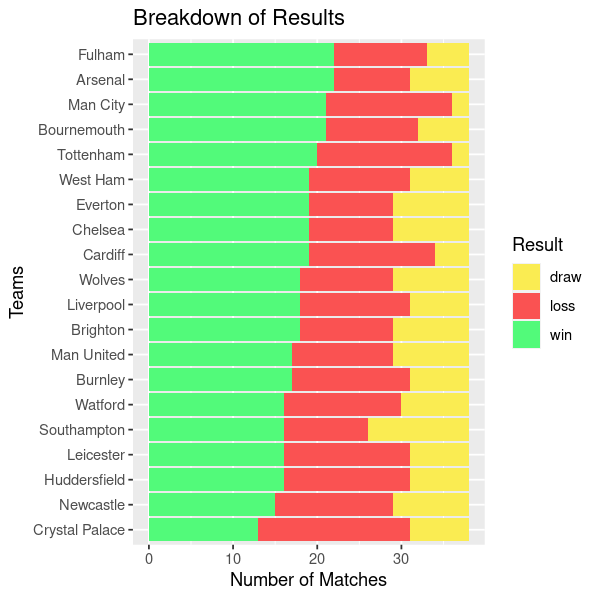

In [115]:
total_win <- soccer_long %>%
	group_by(team) %>% 
	filter(result == "win") %>%
	summarize(win = n()) %>% arrange(desc(win))

total_loss <- soccer_long %>%
	group_by(team) %>% 
	filter(result == "loss") %>%
	summarize(loss = n()) %>% arrange(desc(loss))
	
total_draw <- soccer_long %>%
	group_by(team) %>% 
	filter(result == "draw") %>%
	summarize(draw = n()) %>% arrange(desc(draw))

full_join(total_win, total_loss) %>% full_join(., total_draw) %>%
	arrange(win) %>%
  	mutate(team = fct_reorder(team, win, .fun = sum)) %>%
	pivot_longer(., cols = c(win, loss, draw), values_to = "count") %>%
	ggplot(., aes(y = team, x = count, fill = name)) + 
	geom_col() + 
	scale_fill_manual(values = c("#faec52", "#fa5252","#52fa7a")) +
	labs(title = "Breakdown of Results", x = "Number of Matches", y = "Teams", fill = "Result") 

### Most Wins

In [116]:
soccer_long %>%
	group_by(team) %>% 
	filter(result == "win") %>%
	summarize(win = n()) %>% top_n(5) %>% arrange(desc(win))

Selecting by win


team,win
<chr>,<int>
Arsenal,22
Fulham,22
Bournemouth,21
Man City,21
Tottenham,20


### Most Losses

In [117]:
soccer_long %>%
	group_by(team) %>% 
	filter(result == "loss") %>%
	summarize(loss = n()) %>% top_n(5) %>% arrange(desc(loss))

Selecting by loss


team,loss
<chr>,<int>
Crystal Palace,18
Tottenham,16
Cardiff,15
Huddersfield,15
Leicester,15
Man City,15


### Most Draws

In [118]:
soccer_long %>%
	group_by(team) %>% 
	filter(result == "draw") %>%
	summarize(draw = n()) %>% top_n(5) %>% arrange(desc(draw))


Selecting by draw


team,draw
<chr>,<int>
Southampton,12
Brighton,9
Chelsea,9
Everton,9
Man United,9
Newcastle,9
Wolves,9


## Who scored the most goals?
 - From 2018 to 2020, Manchester City, Liverpool, Arsenal, Totteham, and Manchester United have scored the most goals in all in all.
 - Although it's not perfectly consistent, higher half time goals seem to result in higher full time goals.

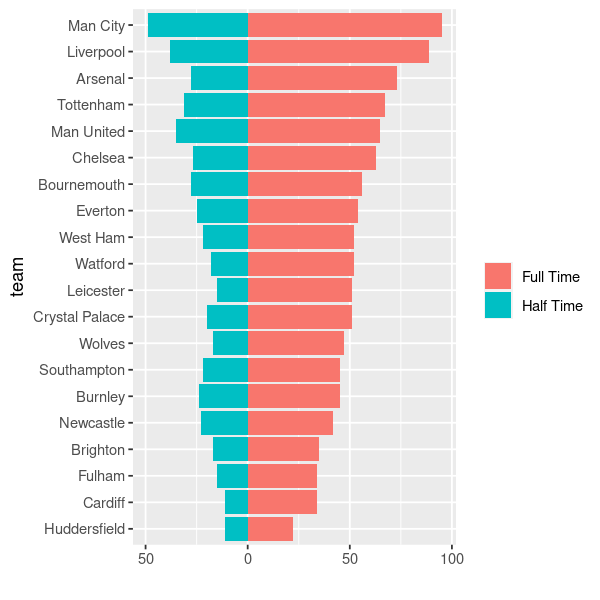

In [119]:
total_goals <- soccer_long %>%
	arrange(ftg) %>%
  	 mutate(team = fct_reorder(team, ftg, .fun = sum)) %>%
	pivot_longer(., cols = c(ftg, htg), 
                 values_to = "goals",
                 names_to = "time") %>%
	mutate(goals = ifelse(time == "htg", goals*(-1), goals*(1)))

total_goals %>% ggplot(., aes(y = team, x = goals, fill = time)) +
	geom_bar(stat = "identity")   +
	scale_x_continuous(
    "", labels =  function(goal) ifelse(abs(goal)>=1000,paste0(abs(goal)/1000, "k"), abs(goal))) +
	 scale_fill_discrete(name = "", labels = c("Full Time", "Half Time"))

## Which teams got the most penalties?
 - Watford, Manchester United, Burnley, Southampton, and Arsenal had the most yellow and red cards in total. 
 - Interestingly, 2 teams which are top goal scorers are also top penalty receivers. Meanwhile, Manchester City is a top goal scorer but a bottom penalty recever

team,total_red,total_foul
<chr>,<dbl>,<dbl>
Leicester,5,351


team,total_yellow,total_foul
<chr>,<dbl>,<dbl>
Watford,77,433


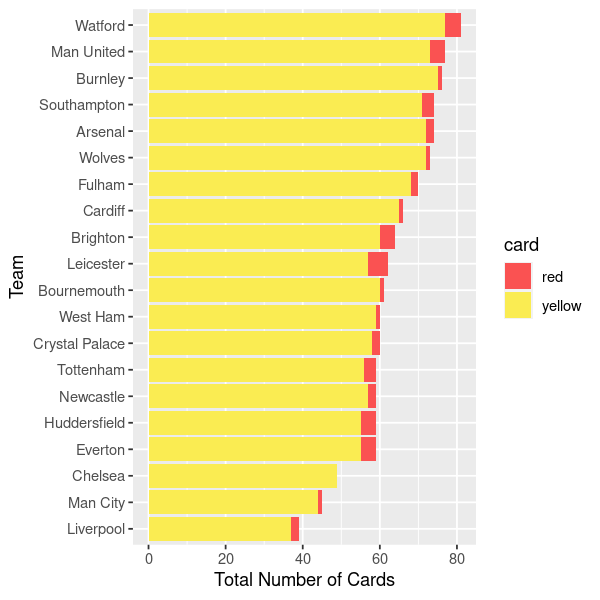

In [120]:
total_cards <- soccer_long %>%
    group_by(team) %>%
    summarize(total_red = sum(red), total_yellow = sum(yellow), total_foul = sum(foul))
total_cards %>% 
	arrange(total_yellow) %>% 
  	mutate(team = fct_reorder(team, total_yellow + total_red, .fun = sum)) %>%
	pivot_longer(. , cols = c(total_red, total_yellow), values_to = "count", names_to = "card", names_prefix = "total_") %>%
	ggplot(., aes(y = team, x = count, fill = card)) + 
		geom_col() + 
		scale_fill_manual(values = c("#fa5252","#faec52")) + 
	labs(x = "Total Number of Cards", y = "Team")
total_cards %>% 
	arrange(desc(total_red)) %>% slice_max(total_red, n = 1) %>% select(-total_yellow)
total_cards %>% 
	arrange(desc(total_yellow)) %>% slice_max(total_yellow, n = 1) %>% select(-total_red)


## Which teams got the most fouls?
 - Meanwhile, Brighton, Watford, Manchester United, Everton, and Fullham commited the most fouls

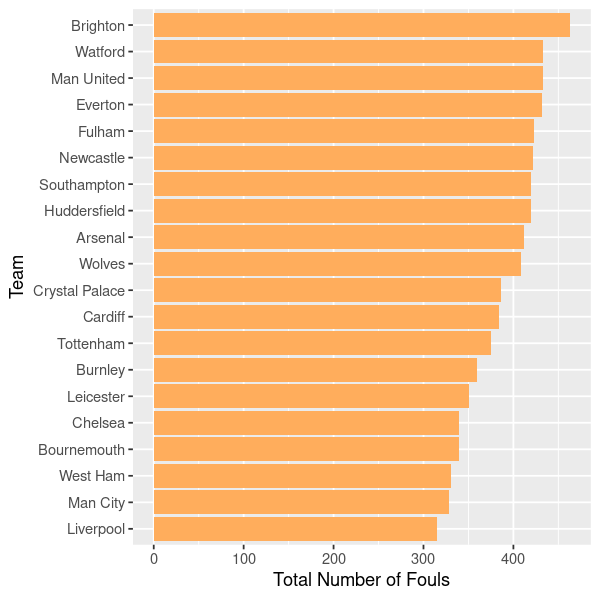

In [121]:
total_cards %>% 
	arrange(total_foul) %>%
  	mutate(team = fct_reorder(team, total_foul, .fun = sum)) %>%
	ggplot(., aes(y = team, x = total_foul)) +
	geom_col(fill = "#ffad5c") + 
	labs(x = "Total Number of Fouls", y = "Team")

## How accurate is each team?
 - Accuracy: By dividing the shots taken on target by the total shots taken, we can study how accurately each team can kick the ball into the goal. By this metric, Manchester United comes out on top with an average of 44.61%
- Success: By dividing the full time score by the total shots taken, we can study how successful each team was at scoring a goal. Surprisingly, Arsenal, which is not among the most accurate teams, has the highest average success rate at 16.16%

team,accuracy
<fct>,<dbl>
Man United,0.4460732
Liverpool,0.3958107
Man City,0.3904870


team,success
<fct>,<dbl>
Arsenal,0.1616312
Liverpool,0.1535819
Burnley,0.1485679


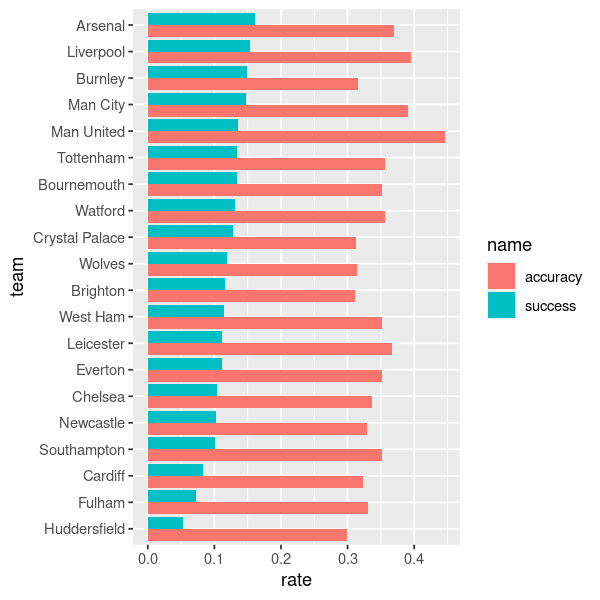

In [122]:
accuracy <- soccer_long %>% 
	mutate(rate_success = ifelse(ftg > 0,  ftg/shots, 0), rate_accuracy = ifelse(st > 0, st/shots, 0)) %>% 
	group_by(team) %>% 
	summarize(accuracy = mean(rate_accuracy), success = mean(rate_success)) %>% arrange(desc(success)) %>%
  	mutate(team = fct_reorder(team, success, .fun = mean)) 
	
accuracy %>%
	pivot_longer(., cols = c(accuracy, success), values_to = "rate") %>%
	ggplot(., aes(y = team, x = rate, fill = name)) + 
		geom_col(position = "dodge")

accuracy %>% 
	arrange(desc(accuracy)) %>% slice_max(accuracy, n = 3) %>% select(-success)

accuracy %>% 
	arrange(desc(success)) %>% slice_max(success, n = 3) %>% select(-accuracy)

## Which teams perform the most corner kicks?
 - Manchester City took the most corner kicks, followed by Liverpool, while Everton, Chelsea, and Arsenal are close behind

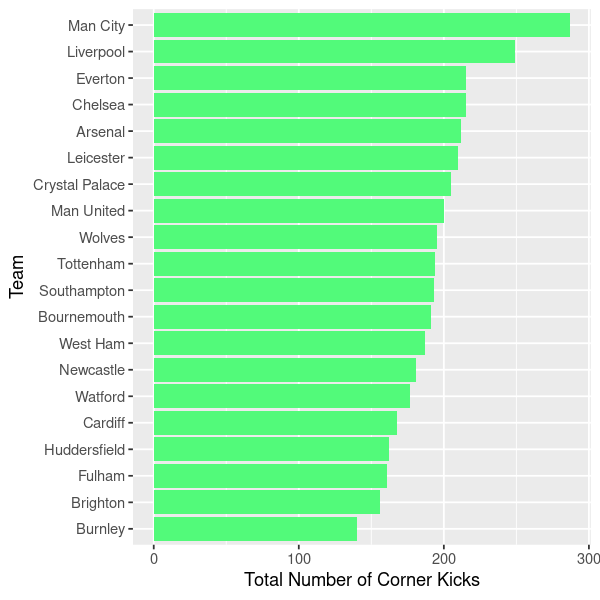

In [123]:
soccer_long %>% 
	arrange(corners) %>%
  	mutate(team = fct_reorder(team, corners, .fun = sum)) %>%
	ggplot(., aes(y = team, x = corners)) +
	geom_col(fill = "#52fa7a") + 
	labs(x = "Total Number of Corner Kicks", y = "Team")

# Predicting Game Results

## Can half time results be used to predict full time results?
 - Using the Goodman and Kruskall's Lambda coefficient, we have determined that knowing the half time results can improve our ability to predict full time results by 34.48%
 - The matrix shows that
 	 - 80 of 128, or 62.% of games won by the away team at half-time were also won at full-time
     - 42 of 71, or  59.15% of games that ended in a draw by half-time also ended in a draw at full-time
     - 106 of 181 or 58.56% of games won by the home team at half-time were also won at full-time
    

In [124]:

result_matrix <- table(half_time = soccer$htr, full_time = soccer$ftr)
result_matrix
DescTools::Lambda(result_matrix, direction = "row")

         full_time
half_time   A   D   H
        A  80  13  13
        D  44  42  62
        H   4  16 106

[1] 0.3448276

## Can we use goals scored in the first half to predict later performance?
 - The plot shows us that half-time and full-time goals are highly correlated. However, this result might be misleading since goals scored in half-time are also counted under full-time. 
 - Since the number of goals is a discrete variable, we add some jitter and transparency to each point on the scatterplot for better visualization. Without modifications, the points will totally align and it will be hard to inspect the plot for trends.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



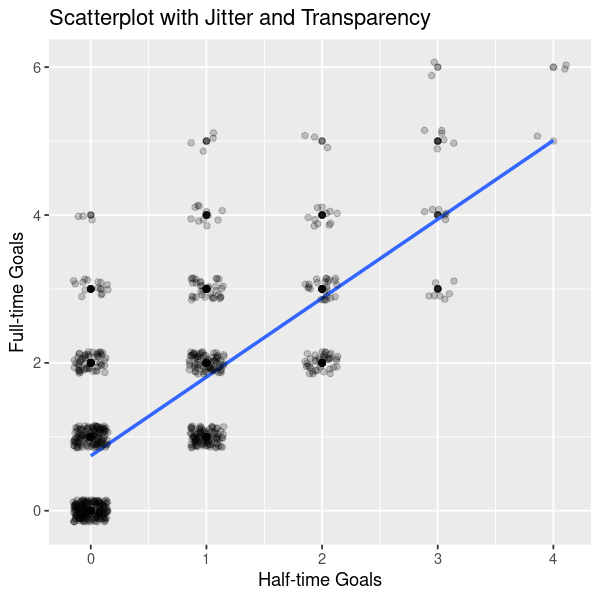

Warning message in cor.test.default(soccer_long$htg, soccer_long$ftg, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  soccer_long$htg and soccer_long$ftg
S = 24449691, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6658168 


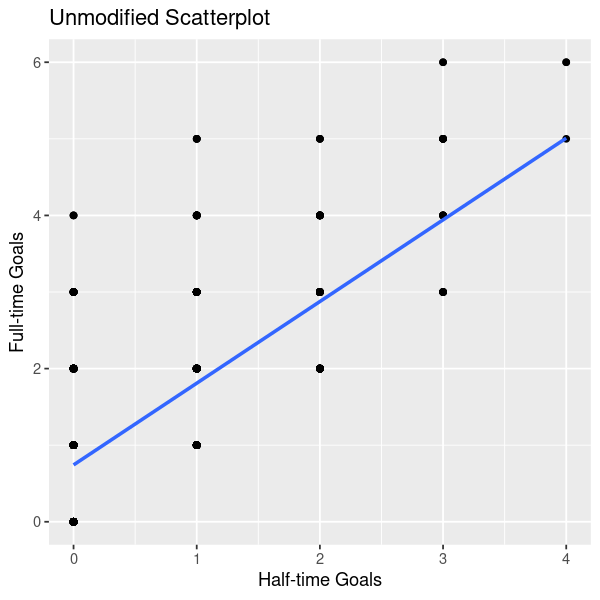

In [125]:
ggplot(soccer_long, aes(x = htg, y = ftg))+
	geom_point(alpha = 0.2) +
	geom_smooth(method="lm", se = F) +
	geom_jitter(width = 0.15, height = 0.15, alpha = 0.2) +
	labs(title = "Scatterplot with Jitter and Transparency", x = "Half-time Goals", y = "Full-time Goals")
ggplot(soccer_long, aes(x = htg, y = ftg)) +
	geom_point()+
	geom_smooth(method="lm", se = F) +
	labs(title = "Unmodified Scatterplot", x = "Half-time Goals", y = "Full-time Goals")

cor.test(soccer_long$htg, soccer_long$ftg, method = "spearman")

 - Therefore, if we want to see if goals scored in the first half can predict goals scored in the second half, a better metric would be the increase in goals between half-time and full-time (or subtracting half-time goals from full-time). 
 - That's a drastic decrease in correlation. That might be a sign that number of goals scored in the first half is not a good predictor of future goals. 

`geom_smooth()` using formula 'y ~ x'

Warning message in cor.test.default(soccer_long$htg, soccer_long$ftg - soccer_long$htg, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  soccer_long$htg and soccer_long$ftg - soccer_long$htg
S = 69251945, p-value = 0.141
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.05345079 


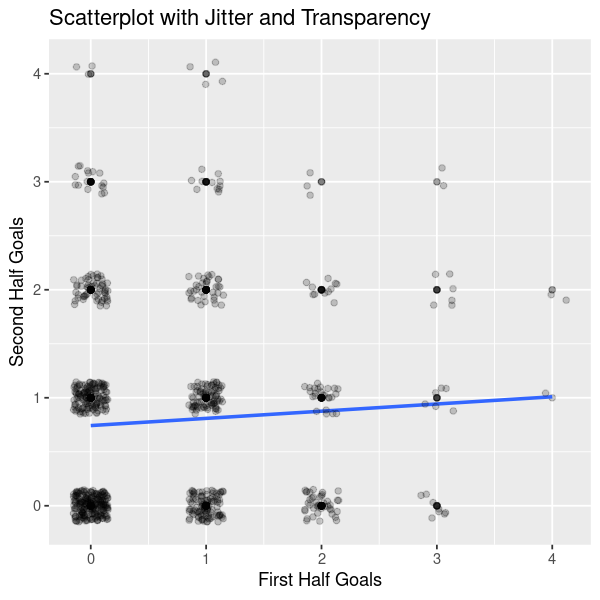

In [126]:
ggplot(soccer_long, aes(x = htg, y = ftg-htg)) +
	geom_point(alpha = 0.2) +
	geom_smooth(method="lm", se = F) +
	geom_jitter(width = 0.15, height = 0.15, alpha = 0.2) +
	labs(title = "Scatterplot with Jitter and Transparency", x = "First Half Goals", y = "Second Half Goals")

cor.test(soccer_long$htg, soccer_long$ftg - soccer_long$htg, method = "spearman")

## Is there a relationship between total number of penalties and total number of matches won?
 - For each team, having a higher total number of red card or yellow card penalties is associated with having a lower total number of wins. Still, it appears that this correlation is weak.
 - Meanwhile, the correlation between fouls and matches won appears stronger. For each team, having a higher number of total fouls leads to a lower number of total wins.

### Total Wins & Total Red Cards per Team
 - The Spearman's rank correlation rho tells us that a higher number of red cards is associated with a lower number of total wins per team ($\rho = -0.42$)
 - At 90% confidence level, the two variables have a significant relationship with one another.

Joining, by = "team"
Joining, by = "team"
`geom_smooth()` using formula 'y ~ x'

Warning message in cor.test.default(penalty_win$total_red, penalty_win$win, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  penalty_win$total_red and penalty_win$win
S = 1885.6, p-value = 0.06683
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.4177537 


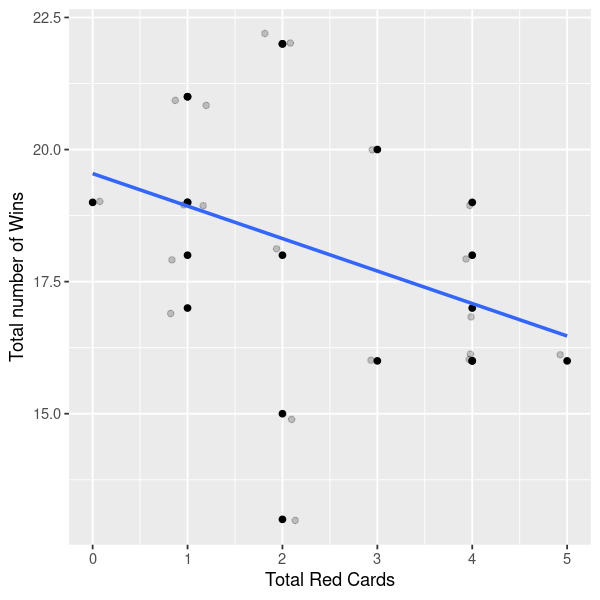

In [127]:
penalty_win <- soccer_long %>%
	group_by(team) %>%
	count(result) %>% #
	pivot_wider(names_from = "result", values_from = "n") %>%
	full_join(., accuracy) %>%
	full_join(., total_cards)

penalty_win %>%
	ggplot(., aes(y = win, x = total_red)) +
		geom_point() +
		geom_jitter(width = 0.2, height = 0.2, alpha = 0.2) +
		geom_smooth(method = "lm", se = F) + 
		labs(y = "Total number of Wins", x = "Total Red Cards")
cor.test(penalty_win$total_red, penalty_win$win, method = "spearman")



### Total Wins & Total Yellow Cards per Team
 - The Spearman's rank correlation rho tells us that a higher number of yellow cards is associated with a lower number of total wins per team ($\rho = -0.10$)
 - At 90% confidence level, there is insufficient evidence to say that this relationship is significant.

`geom_smooth()` using formula 'y ~ x'

Warning message in cor.test.default(penalty_win$total_yellow, penalty_win$win, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  penalty_win$total_yellow and penalty_win$win
S = 1458, p-value = 0.6865
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.09623799 


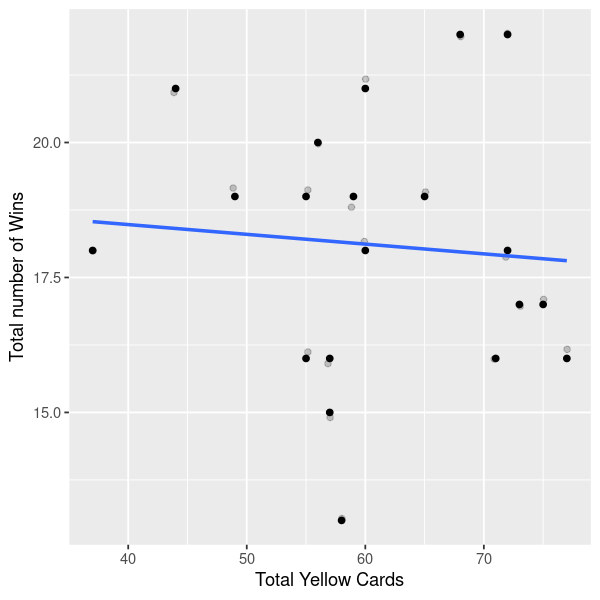

In [128]:
penalty_win %>%
	ggplot(., aes(y = win, x = total_yellow)) +
		geom_point() +
		geom_jitter(width = 0.2, height = 0.2, alpha = 0.2) +
		geom_smooth(method = "lm", se = F) + 
		labs(y = "Total number of Wins", x = "Total Yellow Cards")
cor.test(penalty_win$total_yellow, penalty_win$win, method = "spearman")

### Total Wins & Total Fouls per Team
 - The Spearman's rank correlation rho tells us that a higher number of fouls is associated with a lower number of total wins per team ($\rho = -0.21$)
 - However, at 90% confidence level, there is insufficient evidence to say that this relationship is significant.

`geom_smooth()` using formula 'y ~ x'

Warning message in cor.test.default((penalty_win$total_yellow + penalty_win$total_foul), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  (penalty_win$total_yellow + penalty_win$total_foul) and penalty_win$win
S = 1612, p-value = 0.3695
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2120164 


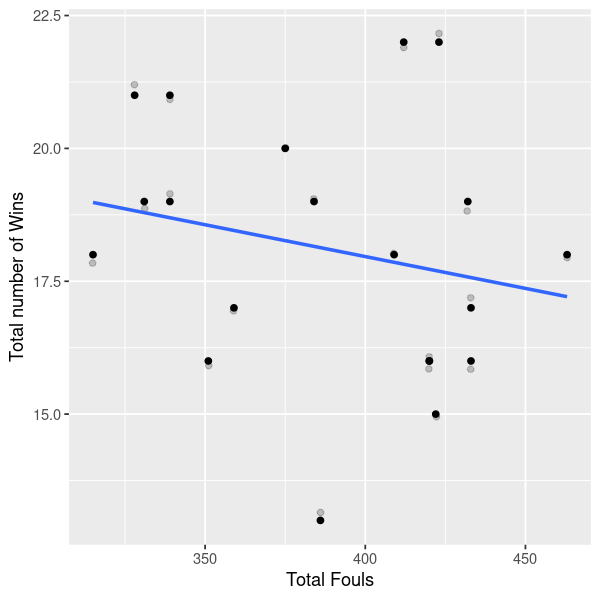

In [129]:
penalty_win %>%
	ggplot(., aes(y = win, x = total_foul)) +
		geom_point() +
		geom_jitter(width = 0.2, height = 0.2, alpha = 0.2) +
		geom_smooth(method = "lm", se = F) + 
		labs(y = "Total number of Wins", x = "Total Fouls")
cor.test((penalty_win$total_yellow + penalty_win$total_foul), penalty_win$win, method = "spearman")